In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
path = '/kaggle/input/colorization/'



In [4]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255) # instantiate datagenerator and rescale

#Resize images, if needed
train = train_datagen.flow_from_directory(path, 
                                          target_size=(256, 256), 
                                          batch_size=200,
                                          class_mode=None)


#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.

"""

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) # : value are assigned to X
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y we add a tuple to X which is also a tuple
print(X.shape)
print(Y.shape)


Found 472 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(200, 256, 256, 1)
(200, 256, 256, 2)


In [5]:
import tensorflow.keras.backend as K

def psnr_metric(y_true, y_pred):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) for a Keras/TensorFlow model.
    
    Parameters:
        y_true: Ground truth image tensor.
        y_pred: Predicted image tensor.
        
    Returns:
        Tensor: PSNR value.
    """
    max_pixel_value = 1.0  # Assuming images are normalized to [0, 1]
    mse = K.mean(K.square(y_pred - y_true))
    psnr_value = 10.0 * K.log(max_pixel_value ** 2 / mse) / K.log(10.0)
    return psnr_value


In [6]:
def ssi_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0.0, 1.0)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return K.mean(ssim)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import structural_similarity
#Encoder


model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same')) 

#Decoder
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same')) # we are predicting A and B channel that's why we are using two nuerns 
model.add(UpSampling2D((2, 2)))



# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will stop
    verbose=1,           # Prints messages when stopping is triggered
    restore_best_weights=True  # Restores the model weights from the epoch with the best value of the monitored metric
)
model.compile(optimizer='adam', loss=MeanSquaredError() , metrics=[psnr_metric,'accuracy',ssi_metric])
model.summary()




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,219,410 (23.73 MB)

 Trainable params: 6,219,410 (23.73 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history =model.fit(X,Y,validation_split=0.1, epochs=150, batch_size=16)





Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6997 - loss: 0.0163 - psnr_metric: 17.9253 - ssi_metric: 0.4702 - val_accuracy: 0.6511 - val_loss: 0.0181 - val_psnr_metric: 17.7973 - val_ssi_metric: 0.3953
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7000 - loss: 0.0159 - psnr_metric: 18.1298 - ssi_metric: 0.4829 - val_accuracy: 0.6620 - val_loss: 0.0176 - val_psnr_metric: 17.6472 - val_ssi_metric: 0.4004
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7156 - loss: 0.0157 - psnr_metric: 18.0601 - ssi_metric: 0.4864 - val_accuracy: 0.6105 - val_loss: 0.0177 - val_psnr_metric: 18.0249 - val_ssi_metric: 0.3998
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6804 - loss: 0.0158 - psnr_metric: 18.0573 - ssi_metric: 0.4868 - val_accuracy: 0.6166 - val_loss: 0.0180 - val_psnr_metric: 17.7208 - val_ssi_metric: 0.4077
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6993 - loss: 0.0147 - psnr_metric: 18.

In [13]:
model.save('/kaggle/working/PSNR_ssicolorize_encoder100.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


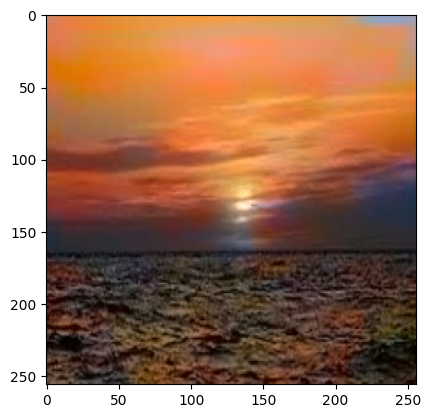

In [14]:
img1_color = []

img1 = img_to_array(load_img('/kaggle/input/colorization/sunset/sunset/images100.jpg'))
img1 = resize(img1, (256,256))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype = float)
img1_color = rgb2lab(1.0 / 255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output = model.predict(img1_color)
output =  output*128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output[0]

plt.imshow(lab2rgb(result))
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/tmp/ipykernel_23/650949892.py:18: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  plt.imshow(lab2rgb(result))


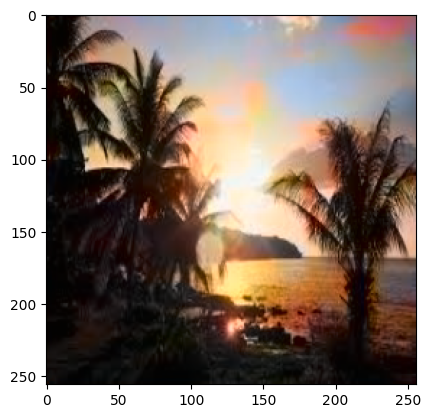

In [15]:
img1_color = []

img1 = img_to_array(load_img('/kaggle/input/colorization/sunset/sunset/images35.jpg'))
img1 = resize(img1, (256,256))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype = float)
img1_color = rgb2lab(1.0 / 255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output = model.predict(img1_color)
output =  output*128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output[0]

plt.imshow(lab2rgb(result))
plt.show()


